<a href="https://colab.research.google.com/github/Glorc12/-1/blob/main/%D0%A1%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D1%86%D0%B5%D0%BD_%D0%BD%D0%B0_%D0%B6%D0%B8%D0%BB%D1%8C%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import hashlib
from datetime import datetime
from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
!pip install spacy
!python -m spacy download ru_core_news_sm
!pip install ratelimit tenacity
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 53.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5895 sha256=8199a79f674be1caa3f25b5c9df27870c84e5d0b8ca37e841edd281fe79140ea
  Stored in directory: /root/.cache/pip/wheels/27/5f/ba/e972a56dcbf5de9f2b7d2b2a710113970bd173c4dcd3d2c902
Successfully built ratelimit


In [2]:
# Подключаем Google Drive для сохранения файлов
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Парсинг с Domclick**

In [ ]:
"""
import requests
import hashlib
from datetime import datetime
from itertools import product
import json
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from ratelimit import limits, RateLimitException
from tenacity import retry, stop_after_attempt, wait_fixed

class DomClickApi:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            "X-Service": "true",
            "Connection": "Keep-Alive",
            "User-Agent": "Android; 12; Google; google_pixel_5; 8.72.0; 8720006; ; NONAUTH"
        })

        # Инициализация (получение cookies)
        self.get("https://api.domclick.ru/core/no-auth-zone/api/v1/ensure_session")
        self.get("https://ipoteka.domclick.ru/mobile/v1/feature_toggles")

    @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
    @limits(calls=10, period=1)
    def get(self, url, **kwargs):
        self.__update_headers(url, **kwargs)
        result = self.session.get(url, **kwargs)
        if result.status_code != 200:
            raise RateLimitException("API response: {}".format(result.status_code), result)
        return result

    def __update_headers(self, url, **kwargs):
        url = self.__get_prepared_url(url, **kwargs)
        sault = "ad65f331b02b90d868cbdd660d82aba0"
        timestamp = str(int(datetime.now().timestamp()))
        encoded = (sault + url + timestamp).encode("UTF-8")
        h = hashlib.md5(encoded).hexdigest()
        self.session.headers.update({
            "Timestamp": timestamp,
            "Hash": "v1:" + h,
        })

    def __get_prepared_url(self, url, **kwargs):
        p = requests.models.PreparedRequest()
        p.prepare(method="GET", url=url, **kwargs)
        return p.url

def fetch_offers(dca, params):
    offers_url = 'https://offers-service.domclick.ru/research/v5/offers/'
    offset = 0
    limit = 10
    offers_list = []

    while True:
        res = dca.get(offers_url, params={**params, 'offset': offset, 'limit': limit})
        try:
            data = res.json()
            if not data['success']:
                break

            offers = data.get("result", {}).get("items", [])
            if not offers:
                break

            offers_list.extend(offers)
            offset += limit

        except json.JSONDecodeError:
            break

    return offers_list

def generate_param_combinations():
    param_grid = {
        'address': ['77fa5072-181d-4264-97be-02498a8f0d5d', '1d1463ae-c80f-4d19-9331-a1b68a85b553',"9930cc20-32c6-4f6f-a55e-cd67086c5171"],
        'deal_type': ['sale'],
        'category': ['living'],
        'offer_type': [['flat'], ['layout']],
        'rooms': [None, 'st', '1', '2', '3', '4+'],
    }

    for params in product(*param_grid.values()):
        yield dict(zip(param_grid.keys(), params))

def save_to_csv(df, filename):
    new_data = df  # Default in case the file does not exist
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        existing_ids = set(existing_df['id'].tolist())
        new_data = df[~df['id'].isin(existing_ids)]  # Filter new data based on existing IDs
        updated_df = pd.concat([existing_df, new_data], ignore_index=True)
    else:
        updated_df = df  # If file doesn't exist, just use the current dataframe

    updated_df.to_csv(filename, index=False)

def process_dataframe(temp_df, columns_needed, unique_ids):
    available_columns = [col for col in columns_needed if col in temp_df.columns]
    temp_df = temp_df[available_columns]
    temp_df = temp_df[~temp_df['id'].isin(unique_ids)]
    return temp_df

def main():
    dca = DomClickApi()
    unique_ids = set()
    max_unique_records = 100000
    columns_needed = [
        'object_info.area', 'object_info.floor', 'object_info.rooms', 'object_info.is_apartment', 'category',
        'has_advance_payment', 'monthly_payment', 'trade_in', 'price_info.price', 'price_info.square_price',
        'price_info.commission', 'price_info.price_for_year', 'price_info.square_price_for_year',
        'legal_options.is_owner', 'legal_options.is_agent_owner_approved', 'offer_type', 'discount_status.status',
        'discount_status.value', 'seo_info.subways', 'seo_info.display_name_parts', 'deal_type', 'status',
        'is_auction', 'id', 'payment_order_id', 'description', 'updated_dt', 'source', 'duplicates_offer_count',
        'address.id', 'address.kind', 'address.guid', 'address.name', 'address.display_name', 'address.parent_id',
        'address.position.lat', 'address.position.lon', 'address.locality.id', 'address.locality.kind',
        'address.locality.guid', 'address.locality.name', 'address.locality.display_name', 'address.locality.parent_id',
        'address.info.timezone', 'address.info.timezone_offset', 'address.short_display_name', 'ipoteka_rate',
        'pessimization.pessimized', 'published_dt', 'assignment_sale', 'house.floors', 'renovation.type',
        'renovation.display_name', 'backwash',
    ]

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(fetch_offers, dca, params) for params in generate_param_combinations()]
        df = pd.DataFrame()

        for future in as_completed(futures):
            offers = future.result()
            temp_df = pd.json_normalize(offers, sep='.')

            if 'id' not in temp_df.columns:
                continue

            temp_df = process_dataframe(temp_df, columns_needed, unique_ids)
            unique_ids.update(temp_df['id'].tolist())
            df = pd.concat([df, temp_df], ignore_index=True)

            if len(unique_ids) >= max_unique_records:
                break

    save_to_csv(df, 'offers_part_0.csv')

if __name__ == "__main__":
    main()
"""

'\nimport requests\nimport hashlib\nfrom datetime import datetime\nfrom itertools import product\nimport json\nimport pandas as pd\nimport os\nfrom concurrent.futures import ThreadPoolExecutor, as_completed\nfrom ratelimit import limits, RateLimitException\nfrom tenacity import retry, stop_after_attempt, wait_fixed\n\nclass DomClickApi:\n    def __init__(self):\n        self.session = requests.Session()\n        self.session.headers.update({\n            "X-Service": "true",\n            "Connection": "Keep-Alive",\n            "User-Agent": "Android; 12; Google; google_pixel_5; 8.72.0; 8720006; ; NONAUTH"\n        })\n\n        # Инициализация (получение cookies)\n        self.get("https://api.domclick.ru/core/no-auth-zone/api/v1/ensure_session")\n        self.get("https://ipoteka.domclick.ru/mobile/v1/feature_toggles")\n\n    @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))\n    @limits(calls=10, period=1)\n    def get(self, url, **kwargs):\n        self.__update_headers(url, *

# **Подготовка данных**


## Извлечение информации из описания


In [3]:
# Загрузка данных из CSV-файла
df = pd.read_csv('/content/drive/MyDrive/offers_part_0.csv')

# Функция для извлечения информации
def extract_info(description):
    # Проверка, что description - это строка
    if not isinstance(description, str):
        return {}

    info = {}

    # Проверка наличия ключевых характеристик и присвоение значений
    info['repair'] = 'euro_repair' if re.search(r'евроремонт', description, re.IGNORECASE) else (
        'cosmetic_repair' if re.search(r'косметический ремонт', description, re.IGNORECASE) else 'no_repair')

    info['furniture_and_appliances'] = 'fully_furnished' if re.search(r'полностью меблированная', description, re.IGNORECASE) else 'with_appliances'

    info['balcony_loggia'] = 'loggia' if re.search(r'лоджия', description, re.IGNORECASE) else 'balcony'

    info['layout'] = 'open_plan' if re.search(r'свободная планировка', description, re.IGNORECASE) else (
        'studio' if re.search(r'студия', description, re.IGNORECASE) else 'separate_rooms')

    info['parking'] = 'underground_parking' if re.search(r'подземная парковка', description, re.IGNORECASE) else 'nearby_parking'

    info['courtyard'] = 'playgrounds' if re.search(r'детские площадки', description, re.IGNORECASE) else 'green_yard'

    info['sports_and_recreation'] = 'fitness_center' if re.search(r'фитнес-центр', description, re.IGNORECASE) else 'swimming_pool'

    info['shopping_centers'] = 'shopping_mall' if re.search(r'торговый центр', description, re.IGNORECASE) else 'shops'

    info['schools_and_kindergartens'] = 'school' if re.search(r'школа', description, re.IGNORECASE) else 'kindergarten'

    info['medical_facilities'] = 'hospital' if re.search(r'больница', description, re.IGNORECASE) else 'clinic'

    info['property_history'] = 'new_building' if re.search(r'новостройка', description, re.IGNORECASE) else 'secondary_housing'

    info['garbage_chute'] = bool(re.search(r'мусоропровод', description, re.IGNORECASE))

    kitchen_size_match = re.search(r'кухня\s+(\d+(\.\d+)?)\s*кв\.?\s*м', description, re.IGNORECASE)
    info['kitchen_area'] = float(kitchen_size_match.group(1)) if kitchen_size_match else None

    info['heating'] = 'central_heating' if re.search(r'центральное отопление', description, re.IGNORECASE) else 'gas_boiler'

    info['water_supply'] = 'central_water_supply' if re.search(r'центральное водоснабжение', description, re.IGNORECASE) else 'well'

    info['sewage'] = 'central_sewerage' if re.search(r'центральная канализация', description, re.IGNORECASE) else 'septic_tank'

    total_area_match = re.search(r'площадью\s+(\d+(\.\d+)?)\s*кв\.?\s*м', description, re.IGNORECASE)
    info['total_area'] = float(total_area_match.group(1)) if total_area_match else None

    living_area_match = re.search(r'жилая площадь\s+(\d+(\.\d+)?)\s*кв\.?\s*м', description, re.IGNORECASE)
    info['living_area'] = float(living_area_match.group(1)) if living_area_match else None

    return info

# Создание копии DataFrame для обработки
df_copy = df.copy()

# Применение функции ко всем описаниям и добавление столбца
df_copy['characteristics'] = df_copy['description'].apply(extract_info)

# Разделение данных словаря на отдельные столбцы
df_copy = pd.concat([df_copy.drop(columns=['characteristics']), df_copy['characteristics'].apply(pd.Series)], axis=1)

# Сохранение результатов в CSV-файл
df_copy.to_csv('processed_offers.csv', index=False, encoding='utf-8-sig')



#**Предварительная обработка данных**

## Удаление дубликатов

In [4]:
print(f'Data has {df_copy.shape[0]} rows, {df_copy.shape[1]} columns.')

Data has 35255 rows, 73 columns.


In [5]:
# Удаляем дубликаты для минимизации избыточных данных
df_no_duplicates = df_copy.drop_duplicates()
print(f'Data has {df_no_duplicates.shape[0]} rows, {df_no_duplicates.shape[1]} columns.')

Data has 35226 rows, 73 columns.


In [6]:
df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35226 entries, 0 to 35254
Data columns (total 73 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   object_info.area                       35226 non-null  float64
 1   object_info.floor                      22318 non-null  float64
 2   object_info.rooms                      35225 non-null  float64
 3   object_info.is_apartment               30329 non-null  object 
 4   category                               22299 non-null  object 
 5   has_advance_payment                    22318 non-null  object 
 6   monthly_payment                        17474 non-null  float64
 7   trade_in                               35226 non-null  bool   
 8   price_info.price                       35226 non-null  int64  
 9   price_info.square_price                35226 non-null  int64  
 10  price_info.commission                  8692 non-null   float64
 11  price_i

Перечесление колонок и их значений из нашего набора данных

Колонка  | Значение
---------|------------
offer_type  | продажа или аренда
object_info.floor|	этаж квартиры
object_info.rooms|	кол-во комнат
object_info.area|	площадь квартиры
price_info.price|	цена квартиры
price_info.square_price|	цена за квадратный метр
address.position.lat|	географическая широта
address.position.lon|	географическая долгота
seller.agent.is_agent|	является ли продавец агентом
published_dt|	дата публикации
updated_dt|	дата последнего обновления
trade_in|	возможность обмена
source|	источник объявления(?)
ipoteka_rate|	процент по ипотеке
has_advance_payment|	есть ли авансовый платёж
status|	текущий статус объявления
assignment_sale|	продажа по уступке прав
is_placement_paid|	оплачено ли размещение
discount_status.status|	статус скидки
discount_status.value|	размер скидки
address.id|	идентификатор адреса
address.kind|	тип адреса (улица, проспект и т.д.)
address.guid|	уникальный идентификатор адреса
address.parent_id|	идентификатор родительского объекта (район)
address.locality.id|	идентификатор населенного пункта
address.locality.kind|	тип населенного пункта (город, поселок и т.д.)
address.locality.subkind|	подтип населенного пункта
address.locality.parent_id|	идентификатор родительского населенного пункта
house.floors|	кол-во этажей в доме
object_info.is_apartment|	является ли квартира отдельной
category|	категория объявления
monthly_payment|	ежемесячный платеж
price_info.commission|	комиссия
price_info.price_for_year|	цена за год
price_info.square_price_for_year|	цена за квадратный метр за год
legal_options.is_owner|	является ли собственником
legal_options.is_agent_owner_approved|	одобрен ли собственник агентом
discount_status.status|	статус скидки
discount_status.value|	размер скидки
seo_info.subways|	информация о метро
seo_info.display_name_parts|	части отображаемого имени
deal_type|	тип сделки
is_auction|	является ли аукционом
id|	идентификатор объявления
payment_order_id|	идентификатор платежного порядка
description|	описание
duplicates_offer_count|	количество дубликатов объявлений
address.name|	название адреса
address.display_name|	отображаемое имя адреса
address.info.timezone|	часовой пояс
address.info.timezone_offset|	смещение часового пояса
address.short_display_name|	короткое отображаемое имя адреса
pessimization.pessimized|	оптимизировано ли пессимистично
renovation.type|	тип ремонта
renovation.display_name|	отображаемое имя ремонта
backwash|	наличие обратного осмоса
placement_type|	тип размещения
repair|	ремонт
furniture_and_appliances|	мебель и бытовая техника
balcony_loggia|	балкон или лоджия
layout|	планировка
parking|	парковка
courtyard|	двор
sports_and_recreation|	спортивные и развлекательные объекты
shopping_centers|	торговые центры
schools_and_kindergartens|	школы и детские сады
medical_facilities|	медицинские учреждения
property_history|	история собственности
garbage_chute|	мусоропровод
kitchen_area|	площадь кухни
heating|	отопление
water_supply|	водоснабжение
sewage|	канализация
total_area|	общая площадь
living_area| жилая площадь

In [7]:
for column in df_no_duplicates.columns:
    unique_values = df_no_duplicates[column].unique()
    print(f"Уникальные значения для столбца '{column}': {unique_values}")

Уникальные значения для столбца 'object_info.area': [17.7  37.8  16.6  ... 98.71 65.13 69.59]
Уникальные значения для столбца 'object_info.floor': [ 1.  4.  3.  2.  6. 18. 10. 22. 15.  7. 31. 12. 14.  5.  9. 11.  8. 20.
 13. 29. 17. 25. 16. 19. 21. 24. 23. 37. 28. 35. 39. 34. 26. 46. 27. 36.
 77. 41. 51. 33. 44. 30. 43. 32. 38. 40. 57. nan 45. 59. 82. 68. 67. 56.
 47. 60. 79. 48. 62. 52. 69. 61. 49. 53. 66. 50. 63. 64. 42. 54.]
Уникальные значения для столбца 'object_info.rooms': [ 0.  1.  4.  5.  6.  7.  9.  8. 13. 10. 12.  3.  2. 18. 15. 43. nan]
Уникальные значения для столбца 'object_info.is_apartment': [nan True False]
Уникальные значения для столбца 'category': ['living' nan]
Уникальные значения для столбца 'has_advance_payment': [False True nan]
Уникальные значения для столбца 'monthly_payment': [201668. 315002.     nan ...  48317.  77917.  90692.]
Уникальные значения для столбца 'trade_in': [False]
Уникальные значения для столбца 'price_info.price': [12100000 18900000  6700000 

In [8]:
# Явно создаем новый DataFrame, сделав копию
df_cleaned = df_no_duplicates.drop_duplicates().copy()
df_cleaned.drop(columns=[ 'total_area', 'living_area', 'kitchen_area','placement_type' ], inplace=True)
# 1 потому что не будет влиять на целевой показатель,а у остальных 4 слишком мало данных и в добавок у 4 есть слишком много уникальных значений

## Создание и объединение признаков

In [10]:
# 1. Объединяем инфраструктурные признаки
df_cleaned['infrastructure_availability'] = np.where(
    (df_cleaned['shopping_centers'].notnull()) |
    (df_cleaned['schools_and_kindergartens'].notnull()) |
    (df_cleaned['medical_facilities'].notnull()),
    1,  # Если есть хотя бы один объект инфраструктуры, ставим 1
    0   # Если нет ни одного, ставим 0
)

# 2. Объединяем спортивные и дворовые признаки
df_cleaned['sports_infrastructure'] = np.where(
    (df_cleaned['sports_and_recreation'].notnull()) |
    (df_cleaned['courtyard'].notnull()),
    1,  # Если есть хотя бы один из спортивных объектов или двор, ставим 1
    0   # Если нет, ставим 0
)


# Выводим первые строки DataFrame для проверки
print(df_cleaned.head())



   object_info.area  object_info.floor  object_info.rooms  \
0              17.7                1.0                0.0   
1              37.8                4.0                0.0   
2              16.6                1.0                0.0   
3              35.6                3.0                0.0   
4              14.4                1.0                0.0   

  object_info.is_apartment category has_advance_payment  monthly_payment  \
0                      NaN   living               False         201668.0   
1                     True   living               False         315002.0   
2                     True   living               False              NaN   
3                    False   living               False         350002.0   
4                     True   living               False          56667.0   

   trade_in  price_info.price  price_info.square_price  ...  shopping_centers  \
0     False          12100000                   683615  ...             shops   
1     False   

# Причины объединения:
 1. ***Общее влияние на качество жизни***: Наличие торговых центров, школ, медучреждений и спортивных объектов увеличивает ценность недвижимости.
 2. ***Снижение сложности модели***: Меньше признаков упрощает модель и снижает риск переобучения.
 3. ***Более полное представление***: Новый признак учитывает наличие различных объектов инфраструктуры и спортивной инфраструктуры в одном.
 4. ***Упрощение обработки данных***: Объединение позволяет уменьшить количество пропусков.

## Удаление колонок, которые не несут ценности для анализа или модели оценки цен недвижимости

In [11]:
# Подсчитываем количество пропущенных значений в каждом столбце DataFrame
missing_values = df_cleaned.isna().sum()

# Фильтруем столбцы, в которых есть хотя бы одно пропущенное значение
missing_values_filtered = missing_values[missing_values > 0]

# Выводим результат
print(missing_values_filtered)

object_info.floor                        12908
object_info.rooms                            1
object_info.is_apartment                  4897
category                                 12927
has_advance_payment                      12908
monthly_payment                          17752
price_info.commission                    26534
price_info.price_for_year                12908
legal_options.is_owner                   12908
legal_options.is_agent_owner_approved    12908
discount_status.status                   15819
discount_status.value                    20695
seo_info.subways                         19866
seo_info.display_name_parts              13103
payment_order_id                         31745
description                              12908
updated_dt                               12908
duplicates_offer_count                   12908
address.parent_id                        13410
address.locality.parent_id               12914
ipoteka_rate                             12908
pessimization

In [12]:
# Выводим статистическое описание категориальных столбцов DataFrame
df_cleaned.describe(include='object')

,object_info.is_apartment,category,has_advance_payment,legal_options.is_owner,legal_options.is_agent_owner_approved,offer_type,discount_status.status,seo_info.subways,seo_info.display_name_parts,deal_type,...,courtyard,sports_and_recreation,shopping_centers,schools_and_kindergartens,medical_facilities,property_history,garbage_chute,heating,water_supply,sewage
count,30329,22299,22318,22318,22318,35226,19407,15360,22123,35226,...,22318,22318,22318,22318,22318,22318,22318,22318,22318,22318
unique,2,1,2,2,2,2,3,3149,14828,1,...,2,2,2,2,2,2,2,2,2,2
top,False,living,False,False,False,flat,discount_received,[{'guid': '0e62bb61-2c05-483f-9df4-7a8faf03a8b...,[{'guid': '1d1463ae-c80f-4d19-9331-a1b68a85b55...,sale,...,green_yard,swimming_pool,shops,kindergarten,clinic,secondary_housing,False,gas_boiler,well,septic_tank
freq,27989,22299,22265,22110,16048,22318,10600,174,56,35226,...,20932,21004,20887,15048,21900,22244,22040,22260,22307,22315


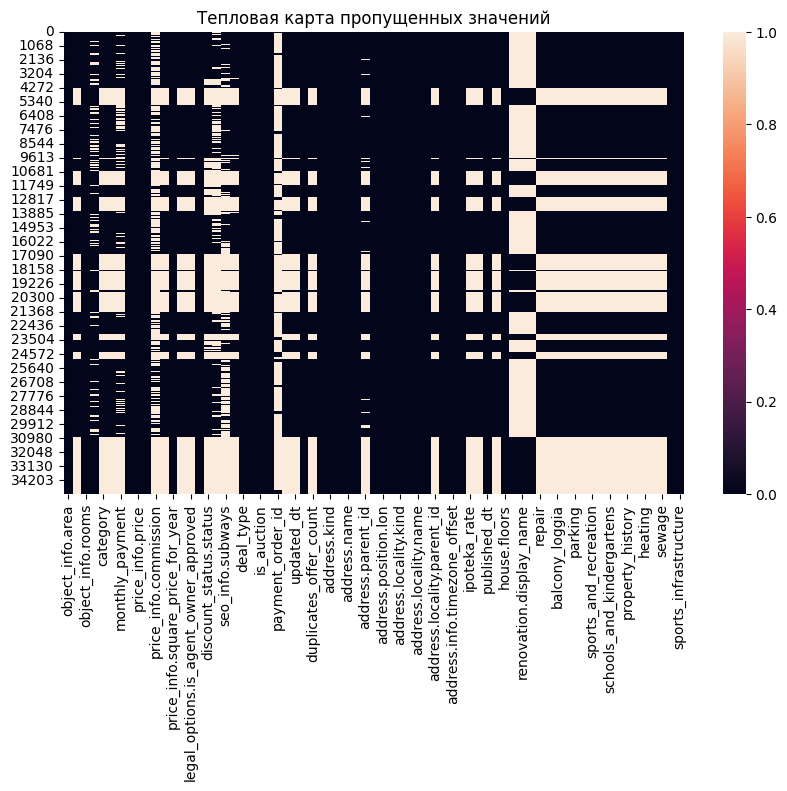

In [13]:
#Тепловая карта (Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.isnull(),)
plt.title('Тепловая карта пропущенных значений')
plt.show()

# **Перекодировка данных**

In [19]:

from sklearn.preprocessing import LabelEncoder

# Список категориальных колонок для кодирования
categorical_columns = [
    'object_info.is_apartment', 'category', 'has_advance_payment', 'seo_info.subways',
    'seo_info.display_name_parts', 'deal_type', 'address.display_name',
    'address.locality.display_name', 'address.short_display_name', 'pessimization.pessimized',
    'assignment_sale', 'repair', 'furniture_and_appliances', 'balcony_loggia', 'layout',
    'parking', 'courtyard', 'sports_and_recreation', 'shopping_centers', 'schools_and_kindergartens',
    'medical_facilities', 'property_history', 'garbage_chute', 'heating', 'water_supply'
]

# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Кодирование категориальных данных
for col in categorical_columns:
    if col in df_cleaned.columns:  # Проверка на наличие колонки в DataFrame
        if df_cleaned[col].nunique() <= 10:  # Порог для применения One-Hot Encoding
            # Применение One-Hot Encoding
            df_baby = pd.get_dummies(df_cleaned, columns=[col], prefix=[col])
        else:
            # Применение Label Encoding
            df_baby[col] = label_encoder.fit_transform(df_baby[col].astype(str))
    else:
        print(f"Колонка '{col}' не найдена в DataFrame.")

# Проверка и вывод закодированных столбцов
print("Столбцы после кодирования:", df_baby.columns)

Столбцы после кодирования: Index(['object_info.area', 'object_info.floor', 'object_info.rooms',
       'object_info.is_apartment', 'category', 'has_advance_payment',
       'monthly_payment', 'trade_in', 'price_info.price',
       'price_info.square_price', 'price_info.commission',
       'price_info.price_for_year', 'price_info.square_price_for_year',
       'legal_options.is_owner', 'legal_options.is_agent_owner_approved',
       'offer_type', 'discount_status.status', 'discount_status.value',
       'seo_info.subways', 'seo_info.display_name_parts', 'deal_type',
       'status', 'is_auction', 'id', 'payment_order_id', 'description',
       'updated_dt', 'source', 'duplicates_offer_count', 'address.id',
       'address.kind', 'address.guid', 'address.name', 'address.display_name',
       'address.parent_id', 'address.position.lat', 'address.position.lon',
       'address.locality.id', 'address.locality.kind', 'address.locality.guid',
       'address.locality.name', 'address.locality.

In [21]:
df_baby.head()

,object_info.area,object_info.floor,object_info.rooms,object_info.is_apartment,category,has_advance_payment,monthly_payment,trade_in,price_info.price,price_info.square_price,...,schools_and_kindergartens,medical_facilities,property_history,garbage_chute,heating,sewage,infrastructure_availability,sports_infrastructure,water_supply_central_water_supply,water_supply_well
0,17.7,1.0,0.0,NaN,living,False,201668.0,False,12100000,683615,...,kindergarten,clinic,secondary_housing,False,gas_boiler,septic_tank,1,1,False,True
1,37.8,4.0,0.0,True,living,False,315002.0,False,18900000,500000,...,kindergarten,clinic,secondary_housing,False,gas_boiler,septic_tank,1,1,False,True
2,16.6,1.0,0.0,True,living,False,NaN,False,6700000,403614,...,school,clinic,secondary_housing,False,gas_boiler,septic_tank,1,1,False,True
3,35.6,3.0,0.0,False,living,False,350002.0,False,21000000,589887,...,kindergarten,clinic,secondary_housing,False,gas_boiler,septic_tank,1,1,False,True
4,14.4,1.0,0.0,True,living,False,56667.0,False,3400000,236111,...,kindergarten,clinic,secondary_housing,False,gas_boiler,septic_tank,1,1,False,True


In [22]:
!pip install plotly pandas

Анализ того какие данные коррелируют с целевым показателем

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def plot_correlation_matrix(df_baby, title='Матрица корреляции'):
    numeric_df = df_baby.select_dtypes(include=[np.number])
    if numeric_df.empty:
        raise ValueError("Нет числовых столбцов для вычисления матрицы корреляции.")

    corr_matrix = numeric_df.corr()

    # Создаем фигуру с помощью plotly
    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.index,
        colorscale='RdBu',
        zmin=-1,
        zmax=1,
        colorbar=dict(title='Корреляция')
    ))

    # Настройка отображения
    fig.update_layout(
        title=title,
        xaxis_title="Столбцы",
        yaxis_title="Столбцы",
        xaxis_tickangle=-45,
        width=1000,
        height=1000,
        margin=dict(l=100, r=100, t=100, b=100)
    )

    # Показываем график
    fig.show()

    # Возвращаем исходный DataFrame
    return df_baby

# Пример использования
data_cleaned = plot_correlation_matrix(df_baby, title='Матрица корреляции')


In [ ]:
columns_to_drop = [
    # Уникальные идентификаторы
    'id', 'payment_order_id',

    # Текстовые данные и источники
    'description',
    'source',

    # Дубликаты
    'duplicates_offer_count',

    # Идентификаторы и дополнительные детали местоположения
    'address.id', 'address.guid', 'address.locality.id', 'address.locality.guid',
    'address.kind', 'address.locality.kind',  # .
    'address.parent_id', 'address.locality.parent_id',
    'address.info.timezone', 'address.info.timezone_offset',
    'address.name', 'address.locality.name',
    'address.short_display_name','updated_dt', 'published_dt',
    # Признаки, связанные с юридическим статусом и типом предложения
    'legal_options.is_owner',
    'legal_options.is_agent_owner_approved',
    'is_auction',
     'pessimization.pessimized',
    # Данные о скидках, опциях и комиссиях
    'discount_status.status', 'discount_status.value',
    'trade_in',
    'backwash',
    'monthly_payment',

    # Данные о ремонте
    'renovation.type', 'renovation.display_name',
    'offer_type','sewage',
    # Признак "цена за квадратный метр в год"
    'price_info.square_price_for_year',
]

# Удаление ненужных колонок для облегчения набора данных и фокусировки на значимых признаках
df_cleaned = df_no_duplicates.drop(columns=columns_to_drop)

| Поле | Причина исключения |
|------|--------------------|
| id | Только для идентификации записей. |
| payment_order_id | Только для идентификации записей. |
| description | Использовалось для получения доп. признаков. |
| source | Источник данных не влияет на цену. |
| duplicates_offer_count | Техническая информация, не значимая для оценки цены. |
| address.id | Идентификаторы адресов нужны для внутреннего учета. |
| address.guid | Идентификаторы адресов нужны для внутреннего учета. |
| address.locality.id | Идентификаторы локализаций нужны для внутреннего учета. |
| address.locality.guid | Идентификаторы локализаций нужны для внутреннего учета. |
| address.kind | Не критично для оценки. |
| address.locality.kind | Не критично для оценки. |
| address.parent_id | Идентификаторы родительских объектов, полезны для построения иерархии. |
| address.locality.parent_id | Идентификаторы родительских объектов, полезны для построения иерархии. |
| address.info.timezone | Часовой пояс не влияет на цену. |
| address.info.timezone_offset | Смещение часового пояса не влияет на цену. |
| address.name | Дублируется полем 'address.display_name'. |
| address.locality.name | Дублируется полем 'address.display_name'. |
| legal_options.is_owner | Не критичен для анализа. |
| legal_options.is_agent_owner_approved | Не оказывает прямого влияния на цену. |
| is_auction | Может носить случайный характер. |
| discount_status.status | Может вносить случайные колебания в цену. |
| discount_status.value | Может вносить случайные колебания в цену. |
| trade_in | Не критичен для оценки стоимости. |
| backwash | Не влияет на целевой показатель. |
| price_info.commission | Не значимы для расчета стоимости. |
| monthly_payment | Связан с условиями кредитования. |
| renovation.type | Дублирует информацию о ремонте. |
| renovation.display_name | Дублирует информацию о ремонте. |
| price_info.square_price_for_year | Необходима только для временных расчетов. |

In [ ]:
df_cleaned.columns

Index(['object_info.area', 'object_info.floor', 'object_info.rooms',
       'object_info.is_apartment', 'category', 'has_advance_payment',
       'price_info.price', 'price_info.square_price', 'price_info.commission',
       'price_info.price_for_year', 'seo_info.subways',
       'seo_info.display_name_parts', 'deal_type', 'status',
       'address.display_name', 'address.position.lat', 'address.position.lon',
       'address.locality.display_name', 'ipoteka_rate', 'assignment_sale',
       'house.floors', 'placement_type', 'repair', 'furniture_and_appliances',
       'balcony_loggia', 'layout', 'parking', 'courtyard',
       'sports_and_recreation', 'shopping_centers',
       'schools_and_kindergartens', 'medical_facilities', 'property_history',
       'garbage_chute', 'kitchen_area', 'heating', 'water_supply',
       'total_area', 'living_area'],
      dtype='object')

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35226 entries, 0 to 35254
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   object_info.area               35226 non-null  float64
 1   object_info.floor              22318 non-null  float64
 2   object_info.rooms              35225 non-null  float64
 3   object_info.is_apartment       30329 non-null  object 
 4   category                       22299 non-null  object 
 5   has_advance_payment            22318 non-null  object 
 6   price_info.price               35226 non-null  int64  
 7   price_info.square_price        35226 non-null  int64  
 8   price_info.commission          8692 non-null   float64
 9   price_info.price_for_year      22318 non-null  float64
 10  seo_info.subways               15360 non-null  object 
 11  seo_info.display_name_parts    22123 non-null  object 
 12  deal_type                      35226 non-null  obje

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35182 entries, 0 to 35254
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   object_info.area               35182 non-null  float64
 1   object_info.floor              22289 non-null  float64
 2   object_info.rooms              35181 non-null  float64
 3   object_info.is_apartment       30287 non-null  object 
 4   category                       22270 non-null  object 
 5   has_advance_payment            22289 non-null  object 
 6   price_info.price               35182 non-null  int64  
 7   price_info.square_price        35182 non-null  int64  
 8   price_info.commission          8690 non-null   float64
 9   price_info.price_for_year      22289 non-null  float64
 10  seo_info.subways               15332 non-null  object 
 11  seo_info.display_name_parts    22095 non-null  object 
 12  deal_type                      35182 non-null  obje

E

In [ ]:
# Предварительная обработка данных

# Добавляем столбец с количеством непустых значений в каждой строке
# Это помогает оценить полноту данных в каждой строке
df_cleaned['filled_count'] = df_cleaned.notnull().sum(axis=1)

# Сортируем датафрейм по количеству непустых значений в строках
# Сортировка по убыванию позволяет выделить строки с наибольшим количеством данных
df_sorted = df_cleaned.sort_values(by='filled_count', ascending=False)

# Оставляем только первые 15000 строк
# Это помогает уменьшить размер датасета, сохраняя наиболее полные записи
df_baby = df_sorted.head(20000)

# Убираем временный столбец 'filled_count'
# Так как он больше не нужен, удаляем его из датафрейма
df_baby = df_baby.drop(columns=['filled_count'])

# Сохраняем результат в файл с именем final_part1_domclick.csv
# Это позволяет сохранить очищенный датасет для дальнейшего использования
df_baby.to_csv('final_part1_domclick.csv', index=False)

# Результат
# Выводим информацию о датафрейме после предварительной обработки
print(df_baby.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 15796 to 14618
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   object_info.area               20000 non-null  float64
 1   object_info.floor              20000 non-null  float64
 2   object_info.rooms              19999 non-null  float64
 3   object_info.is_apartment       17158 non-null  object 
 4   category                       19992 non-null  object 
 5   has_advance_payment            20000 non-null  object 
 6   price_info.price               20000 non-null  int64  
 7   price_info.square_price        20000 non-null  int64  
 8   price_info.commission          8676 non-null   float64
 9   price_info.price_for_year      20000 non-null  float64
 10  seo_info.subways               14686 non-null  object 
 11  seo_info.display_name_parts    19967 non-null  object 
 12  deal_type                      20000 non-null  

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Вычисляем количество выбросов
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = len(outliers)

    # Фильтруем DataFrame, чтобы удалить выбросы
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned, num_outliers

# Пример использования
df_cleaned = df_baby.copy()
total_outliers = 0

for column in df_cleaned.select_dtypes(include=[np.number]).columns:
    df_cleaned, num_outliers = remove_outliers_iqr(df_cleaned, column)
    total_outliers += num_outliers
    print(f"Столбец: {column}, Выбросы удалены: {num_outliers}")

print(f"Всего выбросов удалено: {total_outliers}")

Столбец: object_info.area, Выбросы удалены: 1333
Столбец: object_info.floor, Выбросы удалены: 618
Столбец: object_info.rooms, Выбросы удалены: 3
Столбец: price_info.price, Выбросы удалены: 1400
Столбец: price_info.square_price, Выбросы удалены: 397
Столбец: price_info.commission, Выбросы удалены: 230
Столбец: price_info.price_for_year, Выбросы удалены: 269
Столбец: status, Выбросы удалены: 8
Столбец: address.position.lat, Выбросы удалены: 423
Столбец: address.position.lon, Выбросы удалены: 330
Столбец: ipoteka_rate, Выбросы удалены: 0
Столбец: house.floors, Выбросы удалены: 254
Столбец: infrastructure_availability, Выбросы удалены: 0
Столбец: sports_infrastructure, Выбросы удалены: 0
Всего выбросов удалено: 5265


Заполнение пропусков

In [ ]:
# Заполнение пропущенных значений в 'object_info.is_apartment' модой
mode_value = df_baby['object_info.is_apartment'].mode()[0]
df_baby['object_info.is_apartment'] = df_baby['object_info.is_apartment'].fillna(mode_value)

# Заполнение пропущенных значений в 'price_info.commission' нулями
df_baby['price_info.commission'] = df_baby['price_info.commission'].fillna(0)



<ipython-input-55-24137f7d5661>:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



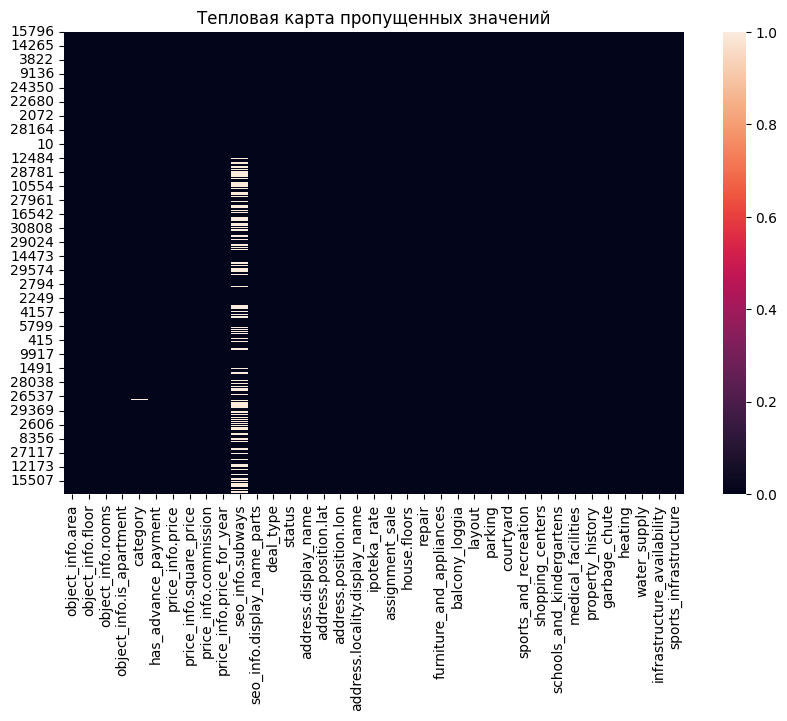

In [ ]:
#Тепловая карта (Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(df_baby.isnull(),)
plt.title('Тепловая карта пропущенных значений')
plt.show()

# **Графики **

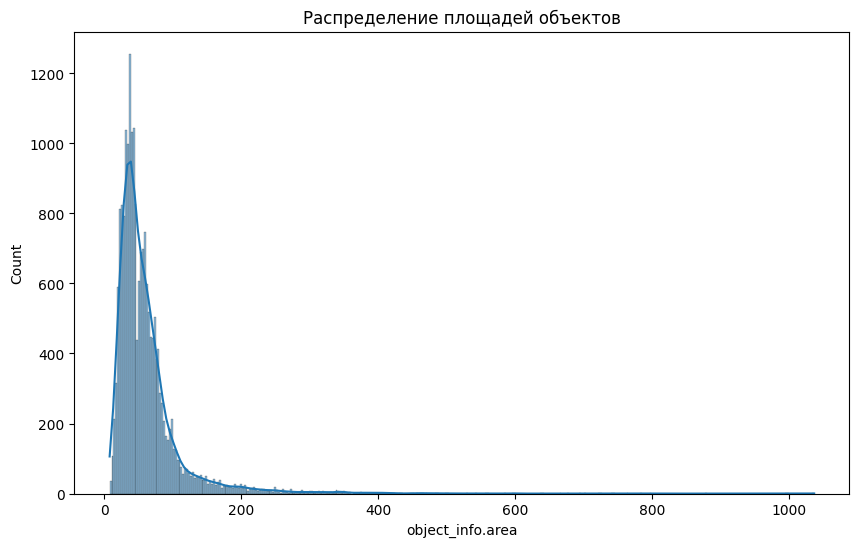

In [ ]:
# Анализ распределения площадей
plt.figure(figsize=(10, 6))
sns.histplot(df_baby['object_info.area'], kde=True)
plt.title('Распределение площадей объектов')
plt.show()


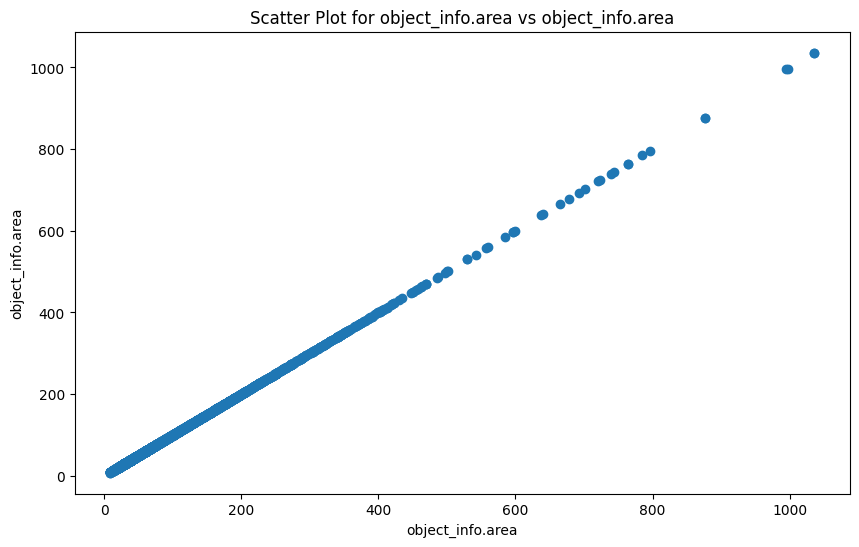

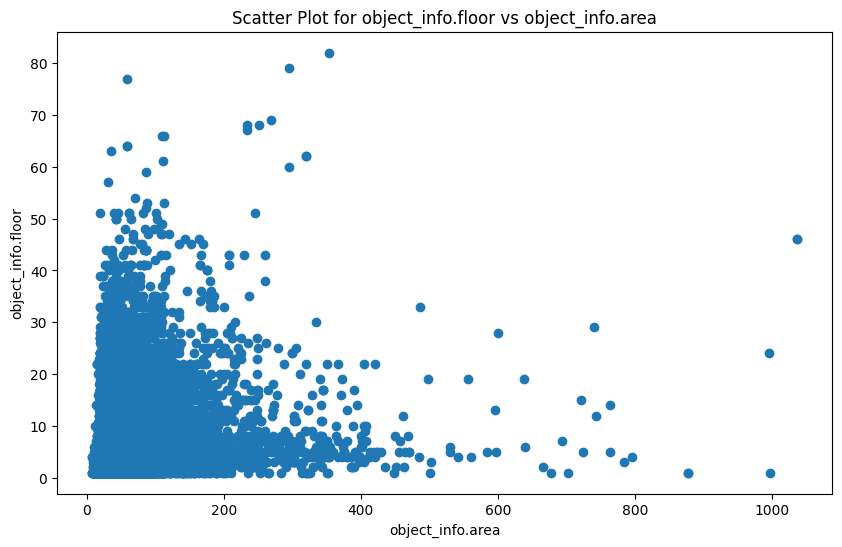

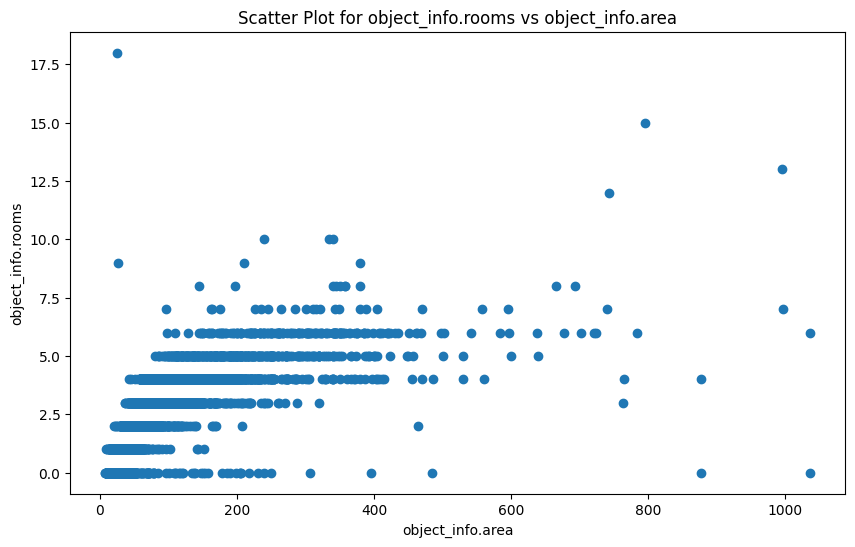

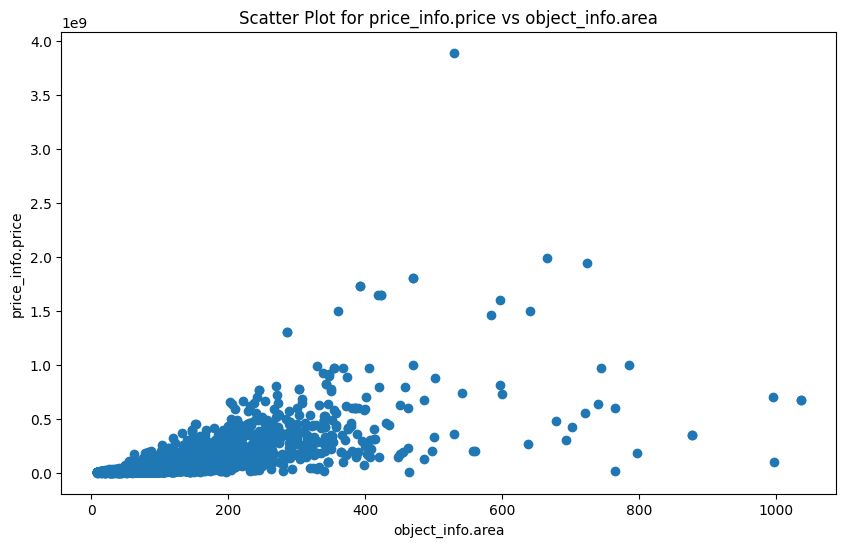

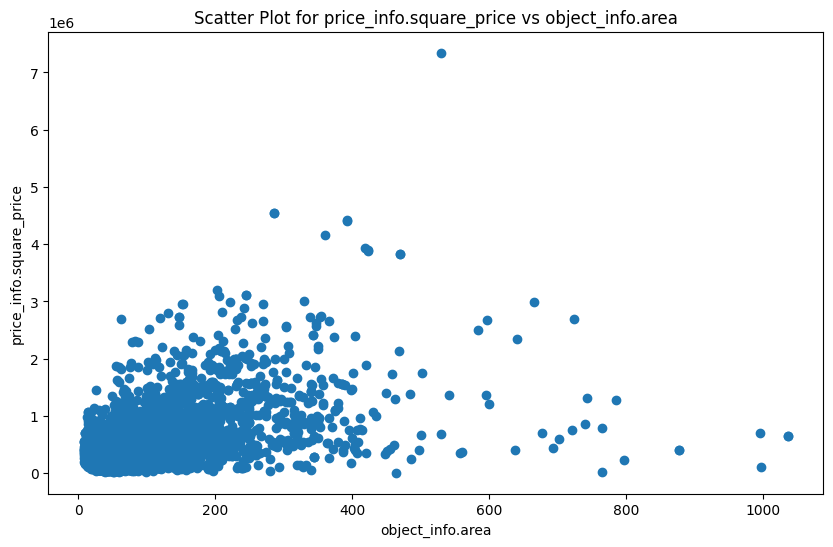

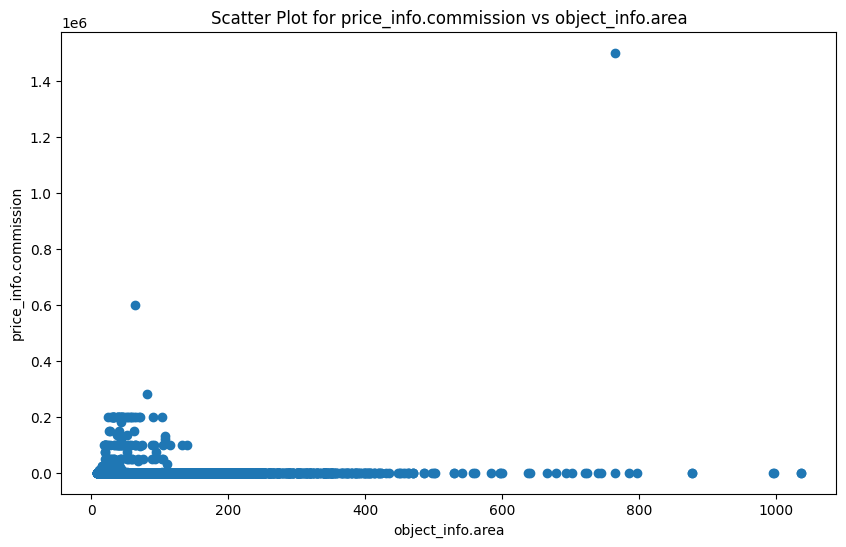

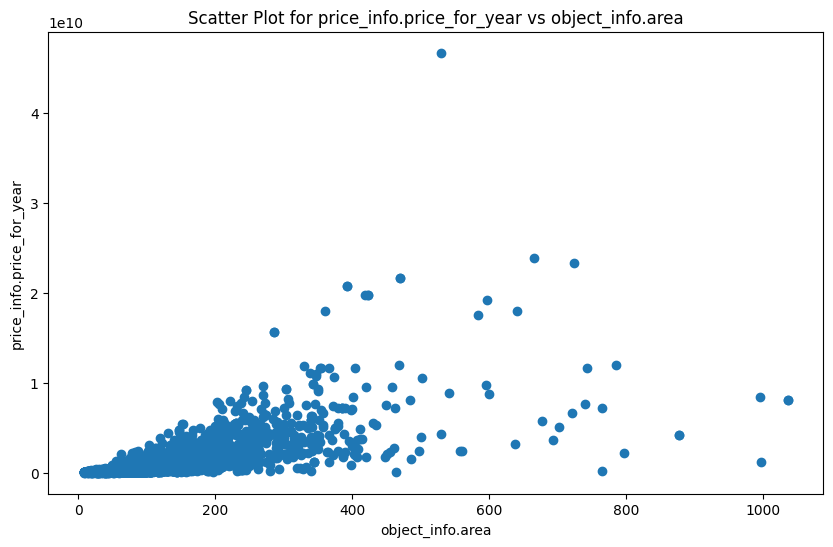

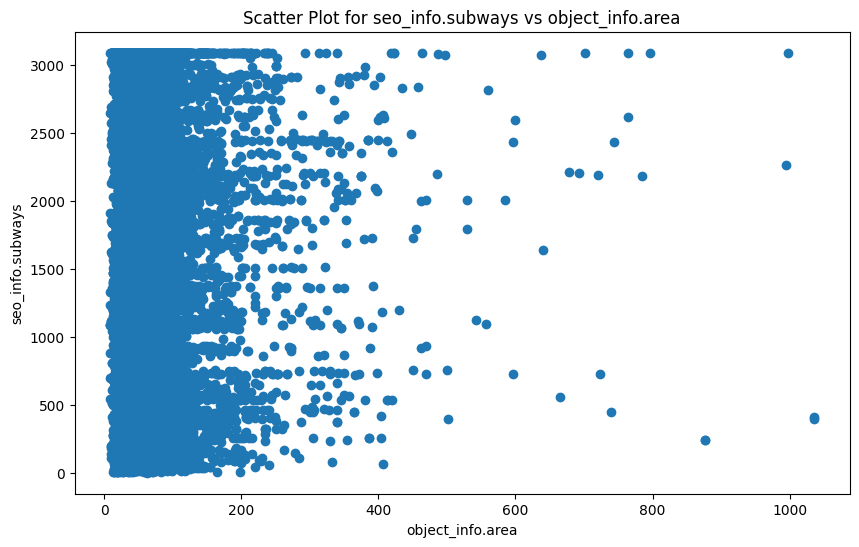

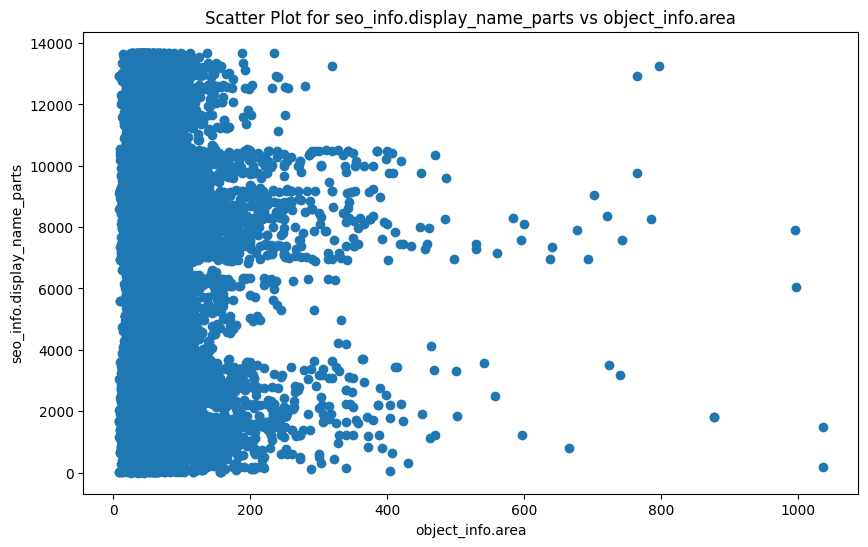

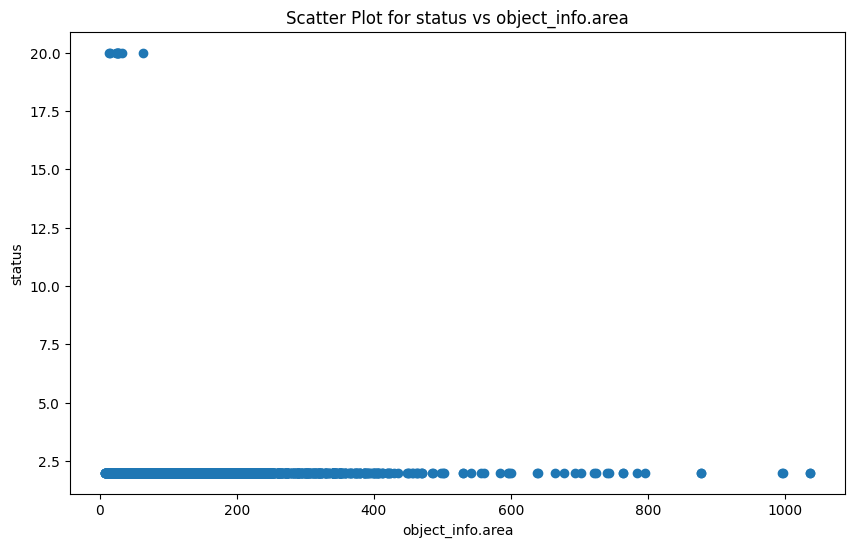

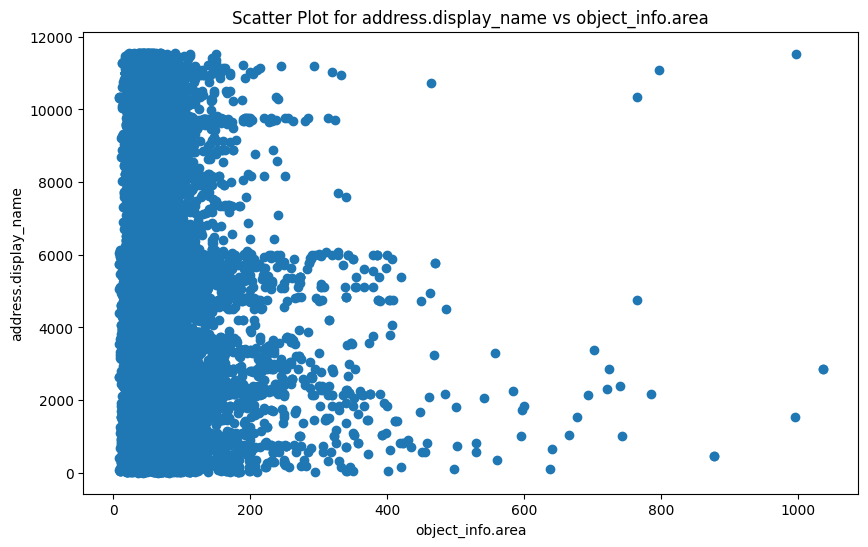

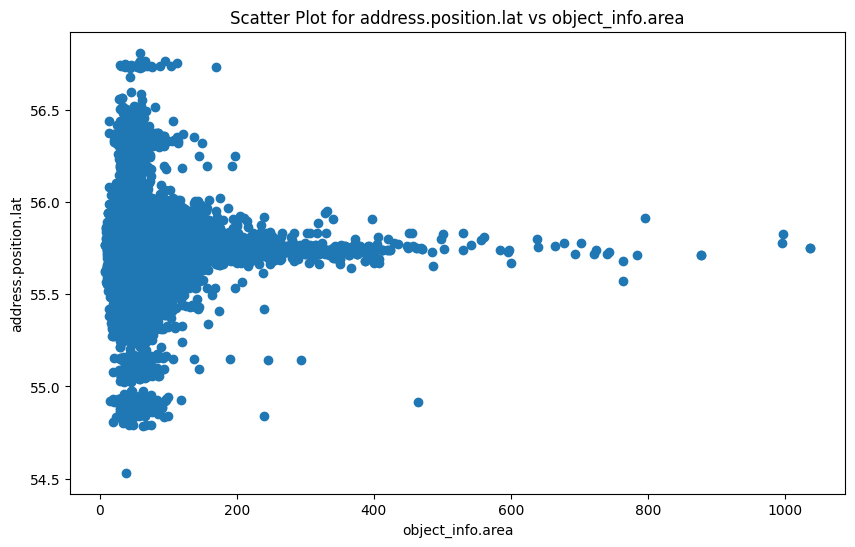

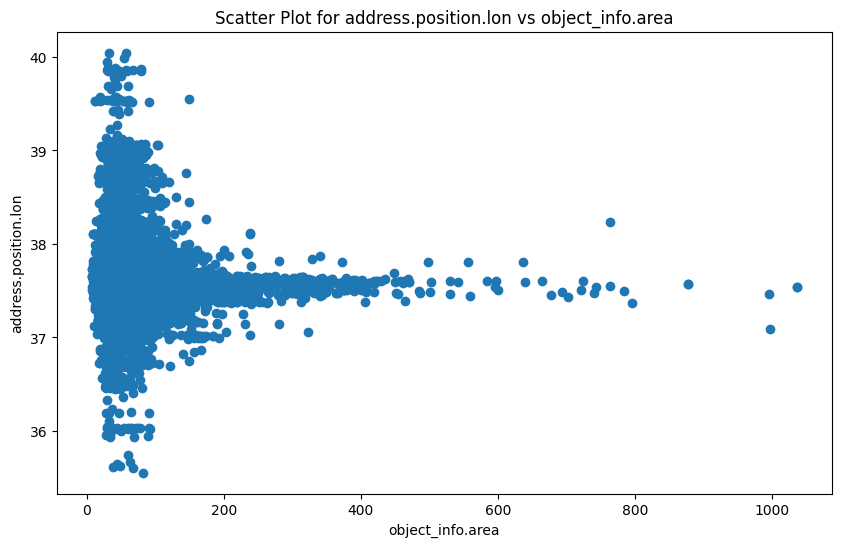

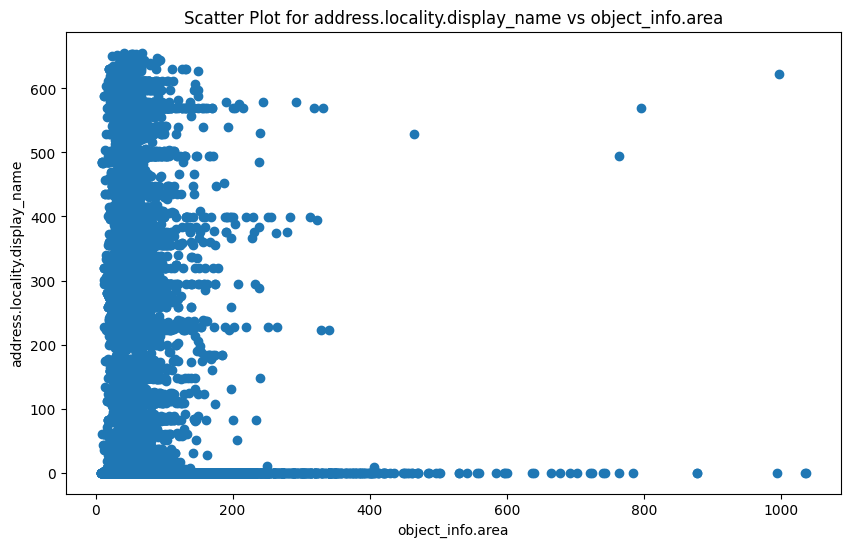

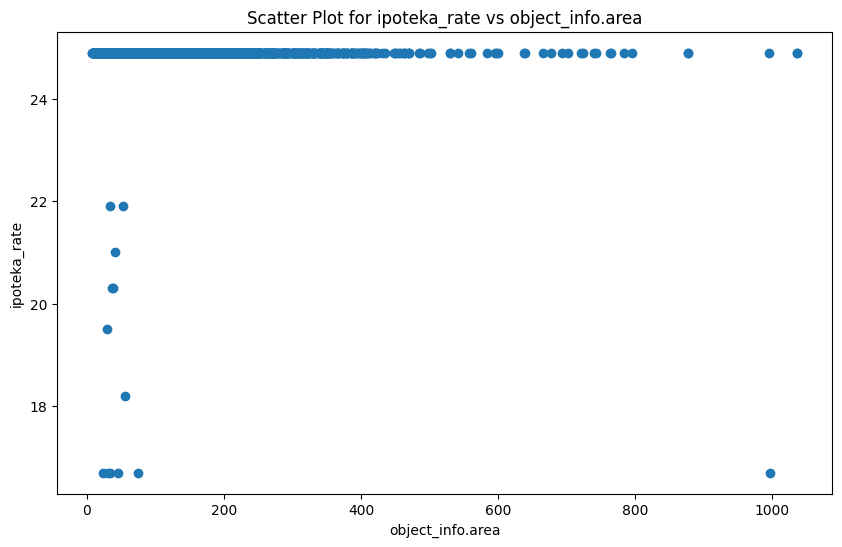

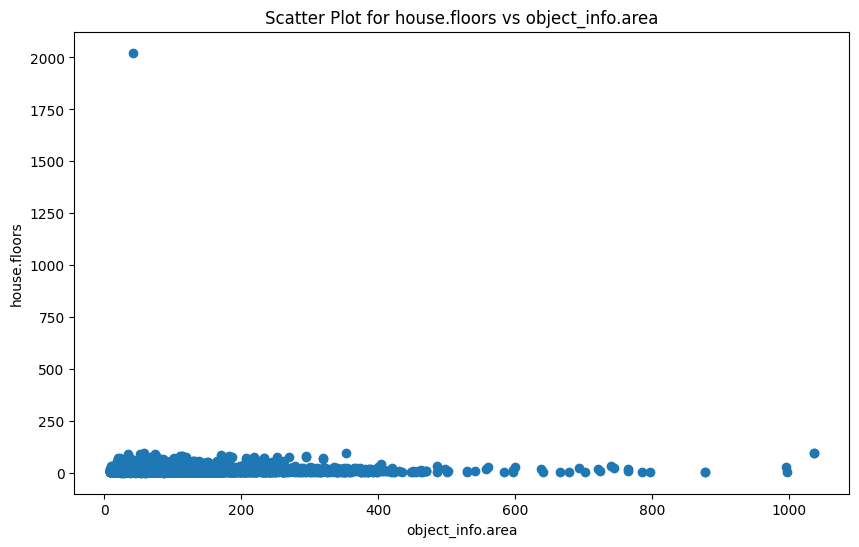

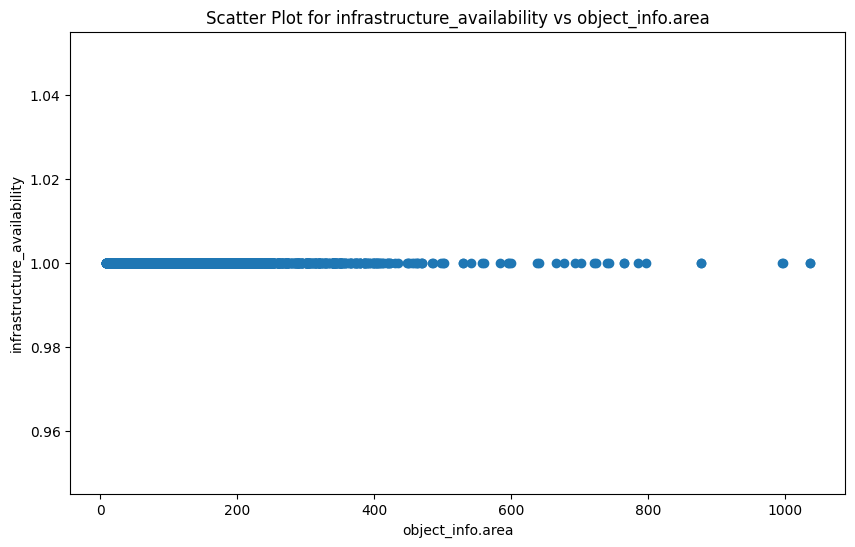

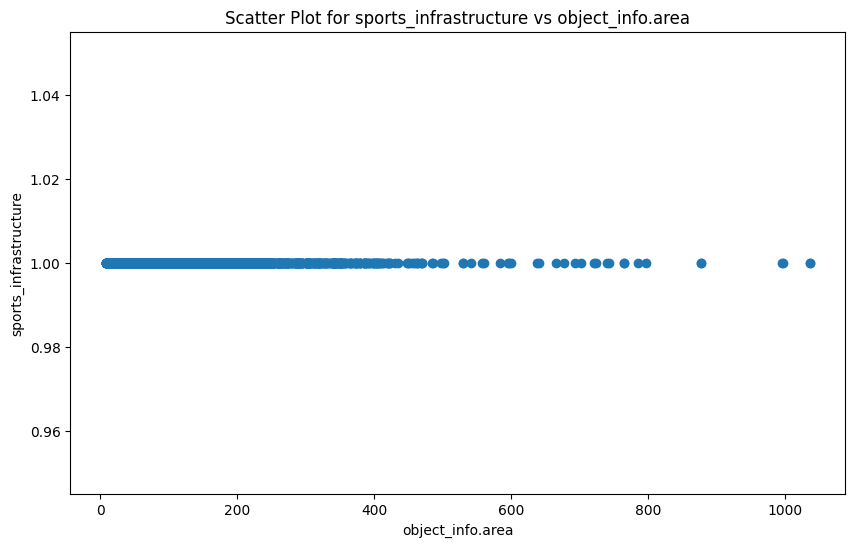

In [71]:
def plot_scatter(df_baby, column, compare_column):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_baby[compare_column], df_baby[column])
    plt.title(f'Scatter Plot for {column} vs {compare_column}')
    plt.xlabel(compare_column)
    plt.ylabel(column)
    plt.show()

# Пример использования
for column in df_baby.select_dtypes(include=[np.number]).columns:
    plot_scatter(df_baby, column, 'object_info.area')

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5966 entries, 15062 to 26085
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   object_info.area               5966 non-null   float64
 1   object_info.floor              5966 non-null   float64
 2   object_info.rooms              5966 non-null   float64
 3   object_info.is_apartment       5933 non-null   object 
 4   category                       5965 non-null   object 
 5   has_advance_payment            5966 non-null   object 
 6   price_info.price               5966 non-null   int64  
 7   price_info.square_price        5966 non-null   int64  
 8   price_info.commission          5966 non-null   float64
 9   price_info.price_for_year      5966 non-null   float64
 10  seo_info.subways               3908 non-null   object 
 11  seo_info.display_name_parts    5952 non-null   object 
 12  deal_type                      5966 non-null   o

In [ ]:
df_cleaned.head()

,object_info.area,object_info.floor,object_info.rooms,object_info.is_apartment,category,has_advance_payment,price_info.price,price_info.square_price,price_info.commission,price_info.price_for_year,...,sports_and_recreation,shopping_centers,schools_and_kindergartens,medical_facilities,property_history,garbage_chute,heating,water_supply,infrastructure_availability,sports_infrastructure
15062,54.6,15.0,2.0,False,living,False,12600000,230769,0.0,151200000.0,...,swimming_pool,shops,kindergarten,clinic,secondary_housing,False,gas_boiler,well,1,1
15045,54.6,6.0,2.0,False,living,False,19000000,347985,0.0,228000000.0,...,swimming_pool,shops,kindergarten,clinic,secondary_housing,False,gas_boiler,well,1,1
15049,36.0,2.0,2.0,False,living,False,12600000,350000,0.0,151200000.0,...,swimming_pool,shops,kindergarten,clinic,secondary_housing,False,gas_boiler,well,1,1
15050,36.9,9.0,2.0,False,living,False,15000000,406504,0.0,180000000.0,...,swimming_pool,shops,kindergarten,clinic,secondary_housing,False,gas_boiler,well,1,1
15051,37.6,2.0,2.0,False,living,False,11300000,300531,0.0,135600000.0,...,swimming_pool,shops,kindergarten,clinic,secondary_housing,False,gas_boiler,well,1,1


In [ ]:
print(df_baby.dtypes)
print(df_baby.head())

object_info.area                            float64
object_info.floor                           float64
object_info.rooms                           float64
price_info.price                              int64
price_info.square_price                       int64
price_info.commission                       float64
price_info.price_for_year                   float64
seo_info.subways                              int64
seo_info.display_name_parts                   int64
status                                        int64
address.display_name                          int64
address.position.lat                        float64
address.position.lon                        float64
address.locality.display_name                 int64
ipoteka_rate                                float64
house.floors                                  int64
infrastructure_availability                   int64
sports_infrastructure                         int64
object_info.is_apartment_False                 bool
object_info.

In [ ]:
data_cleaned = df_baby.drop(columns=['infrastructure_availability', 'sports_infrastructure'])

In [ ]:
data_cleaned = plot_correlation_matrix(data_cleaned, title='Матрица корреляции')

In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 15796 to 14618
Data columns (total 54 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   object_info.area                          20000 non-null  float64
 1   object_info.floor                         20000 non-null  float64
 2   object_info.rooms                         19999 non-null  float64
 3   price_info.price                          20000 non-null  int64  
 4   price_info.square_price                   20000 non-null  int64  
 5   price_info.commission                     20000 non-null  float64
 6   price_info.price_for_year                 20000 non-null  float64
 7   seo_info.subways                          20000 non-null  int64  
 8   seo_info.display_name_parts               20000 non-null  int64  
 9   status                                    20000 non-null  int64  
 10  address.display_name               

Топ-12 переменных с наибольшей корреляцией с price_info.square_price:
Переменная: price_info.price, Корреляция: 0.80
Переменная: price_info.price_for_year, Корреляция: 0.80
Переменная: object_info.area, Корреляция: 0.48
Переменная: address.display_name, Корреляция: -0.42
Переменная: address.locality.display_name, Корреляция: -0.41
Переменная: object_info.rooms, Корреляция: 0.23
Переменная: seo_info.display_name_parts, Корреляция: -0.20
Переменная: seo_info.subways, Корреляция: -0.17
Переменная: object_info.floor, Корреляция: 0.14
Переменная: address.position.lon, Корреляция: -0.13
Переменная: house.floors, Корреляция: 0.10
Переменная: address.position.lat, Корреляция: 0.04


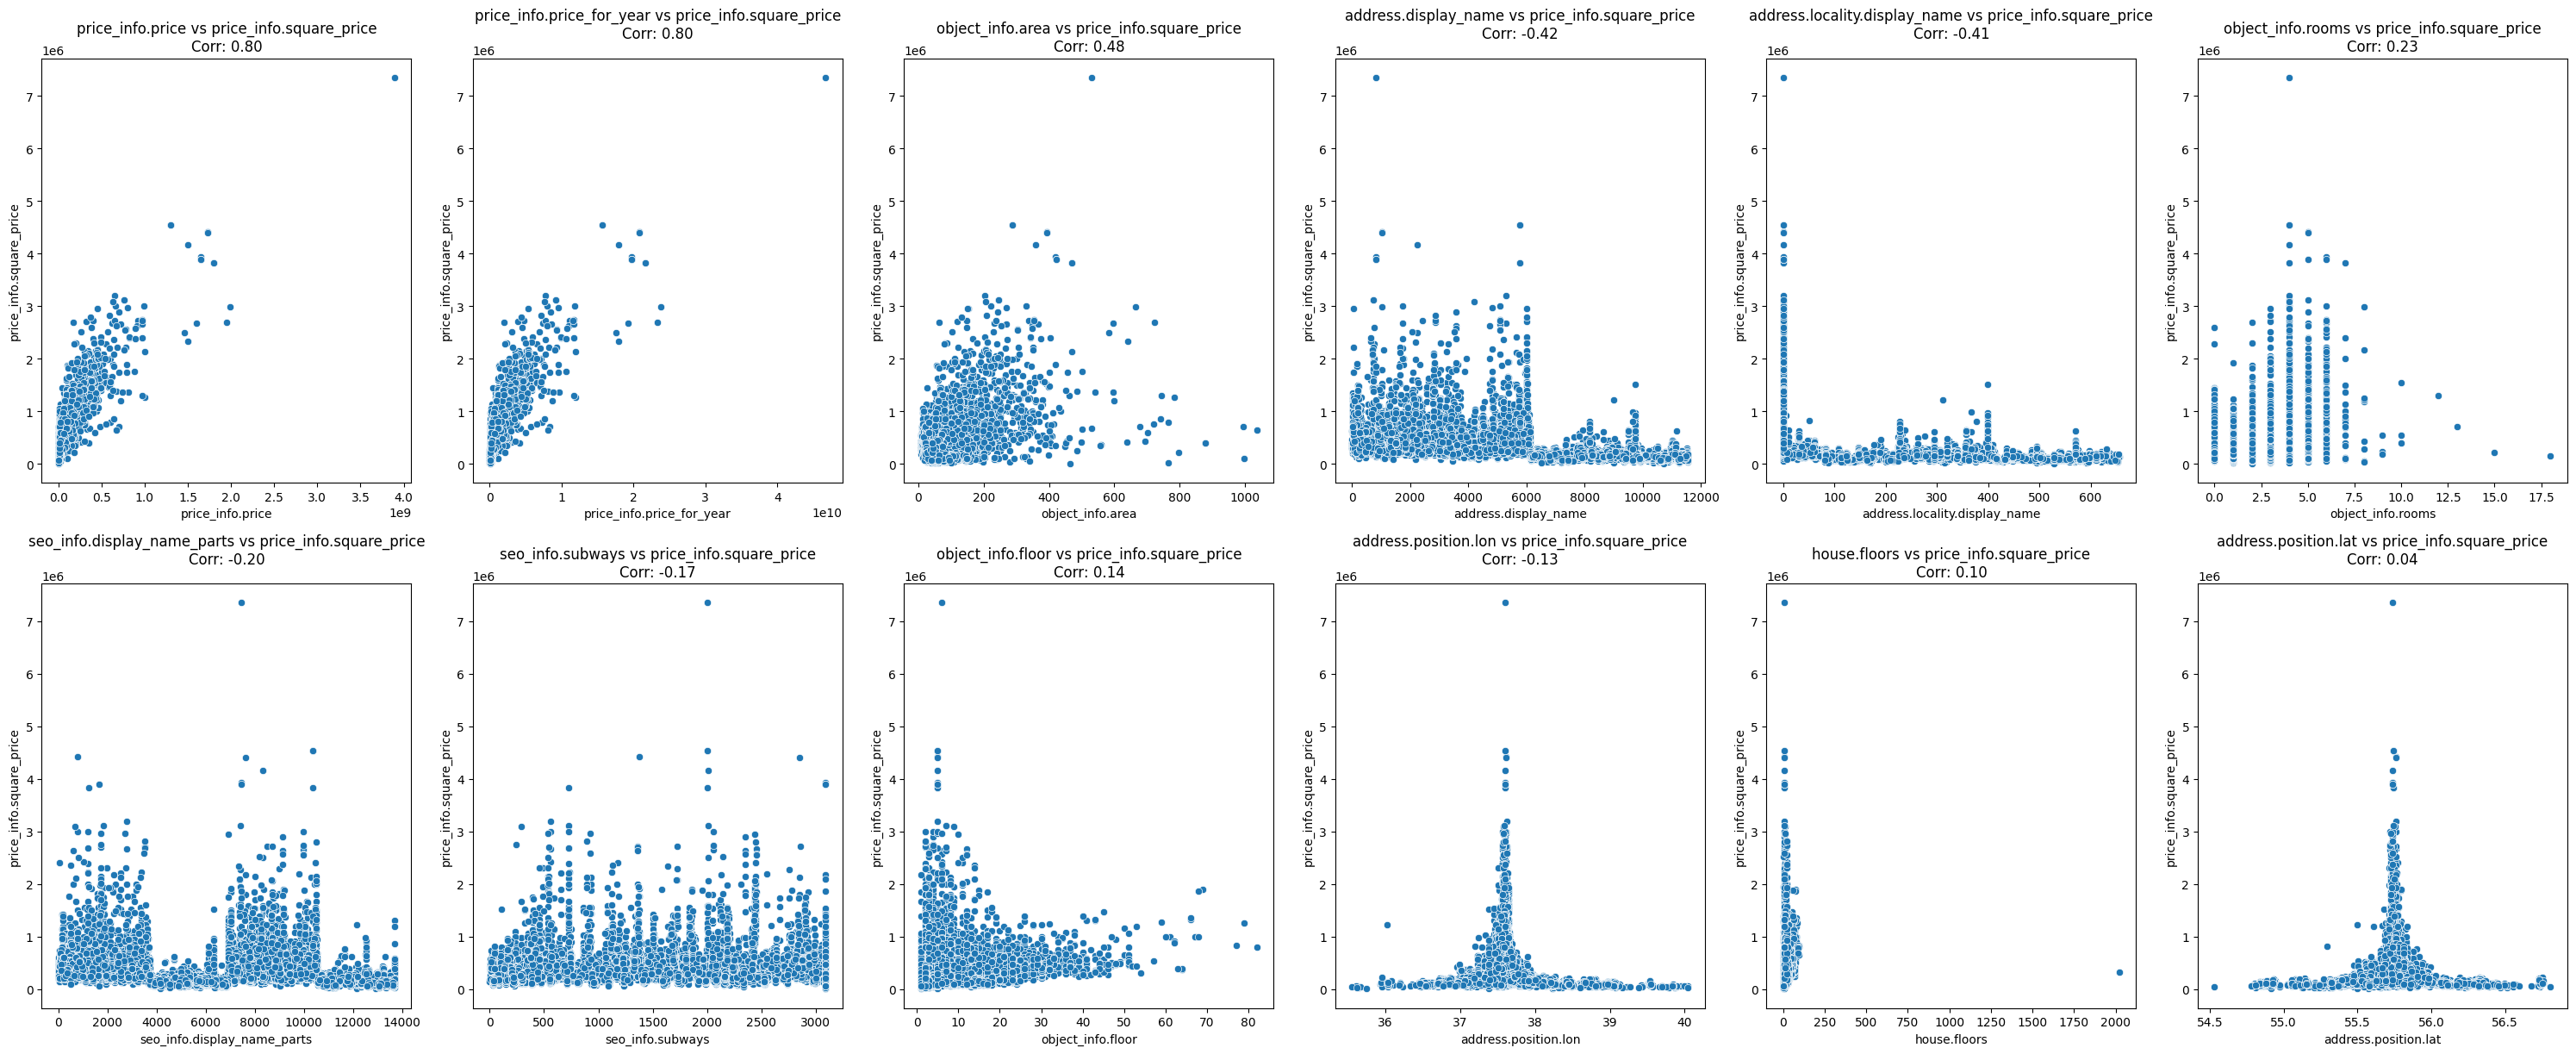

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка NaNs и infs
data_cleaned = df_baby.replace([np.inf, -np.inf], np.nan).dropna()

# Оставляем только числовые столбцы
data_cleaned_numeric = data_cleaned.select_dtypes(include=[np.number])

# Функция для расчета корреляции
def calculate_correlation(data, target_variable):
    correlations = {}
    for column in data.columns:
        if column != target_variable and data[column].nunique() > 1:
            corr, _ = pearsonr(data[target_variable], data[column])
            correlations[column] = corr
    return correlations

# Целевая переменная
target_variable = 'price_info.square_price'

# Расчет корреляций
correlations = calculate_correlation(data_cleaned_numeric, target_variable)

# Сортировка по абсолютному значению корреляции
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Вывод топ-N переменных с наибольшей корреляцией
top_n = 12
print(f"Топ-{top_n} переменных с наибольшей корреляцией с {target_variable}:")
for variable, corr in sorted_correlations[:top_n]:
    print(f"Переменная: {variable}, Корреляция: {corr:.2f}")

# Построение графика рассеяния для топ-N переменных
plt.figure(figsize=(30, 18))
for i, (variable, corr) in enumerate(sorted_correlations[:top_n], 1):
    plt.subplot(3, 6, i)
    sns.scatterplot(x=data_cleaned_numeric[variable], y=data_cleaned_numeric[target_variable])
    plt.title(f'{variable} vs {target_variable}\nCorr: {corr:.2f}')
    plt.xlabel(variable)
    plt.ylabel(target_variable)
plt.tight_layout()
plt.show()


1. ***price_info.price (0.81)*** – Высокая положительная корреляция с ценой за квадратный метр. Это указывает на то, что общая стоимость недвижимости напрямую влияет на цену за квадратный метр. Чем выше стоимость объекта, тем выше его цена за квадратный метр.

2. ***price_info.price_for_year (0.81)*** – Также высокая положительная корреляция, аналогичная предыдущей. Это может говорить о том, что цены, рассчитанные на определенный период, сильно связаны с текущей ценой за квадратный метр.

3. ***object_info.area (0.52)*** – Положительная корреляция среднего уровня. Она показывает, что, в среднем, объекты с большей площадью имеют более высокую цену за квадратный метр. Однако корреляция ниже 1, что может говорить о том, что на цену за квадратный метр влияет не только площадь, но и другие факторы.

4. ***address.locality.display_name (-0.35)*** – Отрицательная корреляция, указывающая на снижение цены за квадратный метр в определенных районах. Это говорит о том, что географическое расположение, особенно на уровне населенного пункта, оказывает значительное влияние на цену недвижимости.

5. ***address.display_name (-0.32)*** **Текст, выделенный полужирным шрифтом**– Схожая отрицательная корреляция, показывающая влияние местоположения. Это подтверждает, что цена за квадратный метр может снижаться в зависимости от конкретного района или адреса.

6. ***address.short_display_name (-0.32)*** – Эта переменная также связана с местоположением. Отрицательная корреляция говорит о снижении стоимости за квадратный метр в зависимости от адреса, что подкрепляет важность расположения объекта для ценообразования.

7. ***object_info.rooms (0.29)*** – Небольшая положительная корреляция. Это говорит о том, что с увеличением количества комнат цена за квадратный метр может немного возрастать, что может быть связано с востребованностью многокомнатных квартир.

8. *schools_and_kindergartens_kindergarten (0.17)* **Текст, выделенный полужирным шрифтом** – Положительная корреляция, что свидетельствует о том, что близость к детским садам может немного повышать цену за квадратный метр. Этот фактор может отражать предпочтения покупателей, для которых наличие инфраструктуры для детей играет роль.

9. ***schools_and_kindergartens_school (-0.17)*** – Небольшая отрицательная корреляция с ценой за квадратный метр. Это может указывать на то, что в районах с большей доступностью школ цена за квадратный метр немного ниже, возможно, из-за того, что такие объекты часто находятся в жилых районах с невысокой стоимостью недвижимости.

10. ***seo_info.display_name_parts (-0.15)*** – Отрицательная корреляция, связанная с элементами отображения информации на веб-сайте. Это может говорить о косвенной связи с местоположением или репутацией районов, что может влиять на спрос и, следовательно, цену за квадратный метр.

***Выводы***:
1. Переменные, связанные с общей ценой и площадью, оказывают наиболее значительное влияние на цену за квадратный метр.
2. Местоположение играет важную роль, так как отрицательные корреляции с параметрами адреса свидетельствуют о снижении цены в зависимости от региона или района.
3. Факторы, связанные с инфраструктурой (например, детские сады и школы), оказывают небольшой, но различный эффект на цену.

# **Создание модели**









In [ ]:
# Импортируем необходимые библиотеки
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Разделяем данные на обучающую и тестовую выборки
X = data_cleaned.drop(columns=['price_info.square_price'])  # Матрица признаков
y = data_cleaned['price_info.square_price']  # Целевая переменная
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация XGBoost регрессора с базовыми параметрами
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.2f}")

Средняя абсолютная ошибка (MAE): 11647.84
Корень из среднеквадратичной ошибки (RMSE): 42396.15
